# Introduction

See README.md

In [1022]:
%reset -f

In [1023]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set(style='darkgrid')  # default style
import tensorflow as tf
np.set_printoptions(precision=3, suppress=True)  # improve float readability
#from sklearn import datasets
from sklearn.model_selection import train_test_split
import copy
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_curve,mean_squared_error,mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data Preparation & Cleaning

### Loading data [David]

In [1024]:
data_file = "./data/final_dataset_20241126.csv"
df_original = pd.read_csv(data_file, encoding='latin-1')

# Data Cleaning
The initial step in data processing involved identifying and removing columns deemed non-essential or redundant for the analysis. 

- **Dropped 'Unnamed: 0' column**:  
  - This column appeared to be an indexing artifact with no analytical value.

- **Removed URL and identifier columns**:  
  - Dropped the 'analysis_url,' 'track_href,' and 'uri' columns because they contained unique URLs and identifiers that were not relevant to the analysis.

- **Excluded the 'id' column**:  
  - The 'id' column was removed as it served solely as a unique identifier and did not provide meaningful insights.

- **Dropped 'search_type' column**:  
  - This column was excluded because its values consistently referred to tracks or artists and did not contribute to feature variability.

- **Removed 'type' column**:  
  - This column was dropped because it contained uniform values (e.g., 'audio_features') or missing data, making it irrelevant for the analysis.

- **Retained 'Artist' and 'Track' columns**:  
  - These columns were kept as they may provide contextual information, such as an artist’s popularity or a track's relevance, which could influence danceability predictions.

These steps were pivotal in ensuring that the dataset was optimized for analysis, containing only relevant information while minimizing noise and redundancy.

In [1025]:
df_original.shape

(4600, 51)

In [1026]:
df_original.columns

Index(['Unnamed: 0', 'Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity',
       'Explicit Track', 'title_artist_id', 'isrc_track_id',
       'spotify_track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

In [1027]:
# Print the data types of each column
print(df_original.dtypes)

Unnamed: 0                      int64
Track                          object
Album Name                     object
Artist                         object
Release Date                   object
ISRC                           object
All Time Rank                  object
Track Score                   float64
Spotify Streams                object
Spotify Playlist Count         object
Spotify Playlist Reach         object
Spotify Popularity            float64
YouTube Views                  object
YouTube Likes                  object
TikTok Posts                   object
TikTok Likes                   object
TikTok Views                   object
YouTube Playlist Reach         object
Apple Music Playlist Count    float64
AirPlay Spins                  object
SiriusXM Spins                 object
Deezer Playlist Count         float64
Deezer Playlist Reach          object
Amazon Playlist Count         float64
Pandora Streams                object
Pandora Track Stations         object
Soundcloud S

In [1028]:
# Check for missing values in each column
missing_values = df_original.isnull().sum()

# Print the number of missing values per column
print(missing_values.sort_values(ascending=False))


TIDAL Popularity              4600
isrc_track_id                 4248
Soundcloud Streams            3333
SiriusXM Spins                2123
Pandora Track Stations        1268
TikTok Posts                  1173
Pandora Streams               1106
Amazon Playlist Count         1055
YouTube Playlist Reach        1009
TikTok Views                   981
TikTok Likes                   980
Deezer Playlist Reach          928
Deezer Playlist Count          921
Spotify Popularity             804
Shazam Counts                  577
Apple Music Playlist Count     561
AirPlay Spins                  498
title_artist_id                384
YouTube Likes                  315
YouTube Views                  308
Spotify Streams                113
Spotify Playlist Reach          72
Spotify Playlist Count          70
valence                         32
acousticness                    32
instrumentalness                32
liveness                        32
duration_ms                     32
uri                 

# Data processing
### Step 1: Handling missing values

The function  coerce_to_numeric was created to make sure objects that are meant to be numeric values are made to numeric. This will allow for subsequent handing of missing values using averages.

In [1029]:
# Make columns into int values
def coerce_to_numeric(list_of_columns):
    '''
    Checks the data type of the columns passed against the original dataset
      Args:
      list_of_columns: a list of columns to be checked

      Returns:
       List of columns that have not successfully been coerced
    '''
    non_successful_list=[]
    for col in list_of_columns:
        try:
            #df_original[col] = df_original[col].str.replace(',', '').astype('float64')
            if df_original[col].dtype not in ['int64', 'float64']:
                df_original[col] = df_original[col].astype(str).str.replace(',', '', regex=False)
                df_original[col] = df_original[col].astype(str).str.replace('nan', '0', regex=False)
                df_original[col]  = df_original[col].fillna(0) 
                df_original[col] = df_original[col].astype(int)
        except Exception as e:
            non_successful_list.append(col)
    return non_successful_list

### Step 2: Determine columns to drop

This step includes iterative checking of non-conformant data which is subsequently dropped to ensure successful running of models.

It starts of by checking all original columns and attempting to coerce them to numeric using the _coerce_to_numeric_ function.

The next step, it checks all columns that are non-numeric and adds them to the list for processing containing columns for dropping.

Lastly the columns are dropped from the original data set

In [1030]:
# Check the values for each column to be dropped
for i in df_original.columns:
    print(df_original[i].head(5))

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64
0           MILLION DOLLAR BABY
1                   Not Like Us
2    i like the way you kiss me
3                       Flowers
4                       Houdini
Name: Track, dtype: object
0    Million Dollar Baby - Single
1                     Not Like Us
2      I like the way you kiss me
3                Flowers - Single
4                         Houdini
Name: Album Name, dtype: object
0     Tommy Richman
1    Kendrick Lamar
2           Artemas
3       Miley Cyrus
4            Eminem
Name: Artist, dtype: object
0    4/26/2024
1     5/4/2024
2    3/19/2024
3    1/12/2023
4    5/31/2024
Name: Release Date, dtype: object
0    QM24S2402528
1    USUG12400910
2    QZJ842400387
3    USSM12209777
4    USUG12403398
Name: ISRC, dtype: object
0    1
1    2
2    3
3    4
4    5
Name: All Time Rank, dtype: object
0    725.4
1    545.9
2    538.4
3    444.9
4    423.3
Name: Track Score, dtype: float64
0      390,470,936
1      323,703

In [1031]:
# Try to coerce the columns to numeric where possible. 
# The functions returns the columns that failed

columns_for_processing=coerce_to_numeric(missing_values.index.to_list())
columns_for_processing

['Track',
 'Album Name',
 'Artist',
 'Release Date',
 'ISRC',
 'title_artist_id',
 'isrc_track_id',
 'spotify_track_id',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url']

In [1032]:
# Check for other non float and non int columnd for removal
for i in df_original.columns:
    if df_original[i].dtype==object:
        if i not in columns_for_processing:
            columns_for_processing.append(i)

columns_for_processing

['Track',
 'Album Name',
 'Artist',
 'Release Date',
 'ISRC',
 'title_artist_id',
 'isrc_track_id',
 'spotify_track_id',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url']

In [1033]:
# Drop the columns with missing values above that could not be coerced into float
df_original = df_original.drop(columns_for_processing,axis=1)

## Step 3: Filling in missing values

One more check for missing values was done. 

Then the column means was used to fill in the missing values for each column. 

TIDAL column was dropped because all values in this column were missing.

In [1034]:
# Check for missing values in each column
missing_values = df_original.isnull().sum()

# Print the number of missing values per column
print(missing_values.sort_values(ascending=False))

TIDAL Popularity              4600
Amazon Playlist Count         1055
Deezer Playlist Count          921
Spotify Popularity             804
Apple Music Playlist Count     561
time_signature                  32
loudness                        32
danceability                    32
energy                          32
key                             32
mode                            32
speechiness                     32
acousticness                    32
instrumentalness                32
liveness                        32
valence                         32
tempo                           32
duration_ms                     32
Soundcloud Streams               0
Explicit Track                   0
Shazam Counts                    0
Unnamed: 0                       0
Pandora Track Stations           0
All Time Rank                    0
Deezer Playlist Reach            0
SiriusXM Spins                   0
AirPlay Spins                    0
YouTube Playlist Reach           0
TikTok Views        

In [1035]:
# Drop tidal popularity
df_original = df_original.drop(['TIDAL Popularity'],axis=1)

In [1036]:
# Check numeric columns
numeric_cols = df_original.select_dtypes(include=['int64', 'float64']).columns
numeric_cols

Index(['Unnamed: 0', 'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

In [1037]:
### “Filling” of null data with average for numeric values
column_means = df_original[numeric_cols].mean()
df_original.fillna(column_means,inplace=True)


### Step 4: Dropping Duplicates

Duplicates were dropped using the 'Unnamed: 0' column, which was a unique identifier

A further check to confirm there were no non-numeric columns was done

In [1038]:
# Drop Duplicates based on 'Unnamed: 0'
df_original = df_original.drop_duplicates(subset='Unnamed: 0', keep='first')

In [1039]:
# Check shape
df_original.shape

(4600, 37)

In [1040]:
# Drop non-numeric columns except Artist
# We shall creating one hot encoding based on artist later
original_cols=df_original.columns
non_numeric_cols= [x for x in original_cols if x not in numeric_cols]
non_numeric_cols

[]

### Step 5 Checking the heat map for correlation

The heatmap was plotted and used to 

1) Check on correlation of the different columns 

2) Feature engineering to reduce dimensionality and improve model performance.

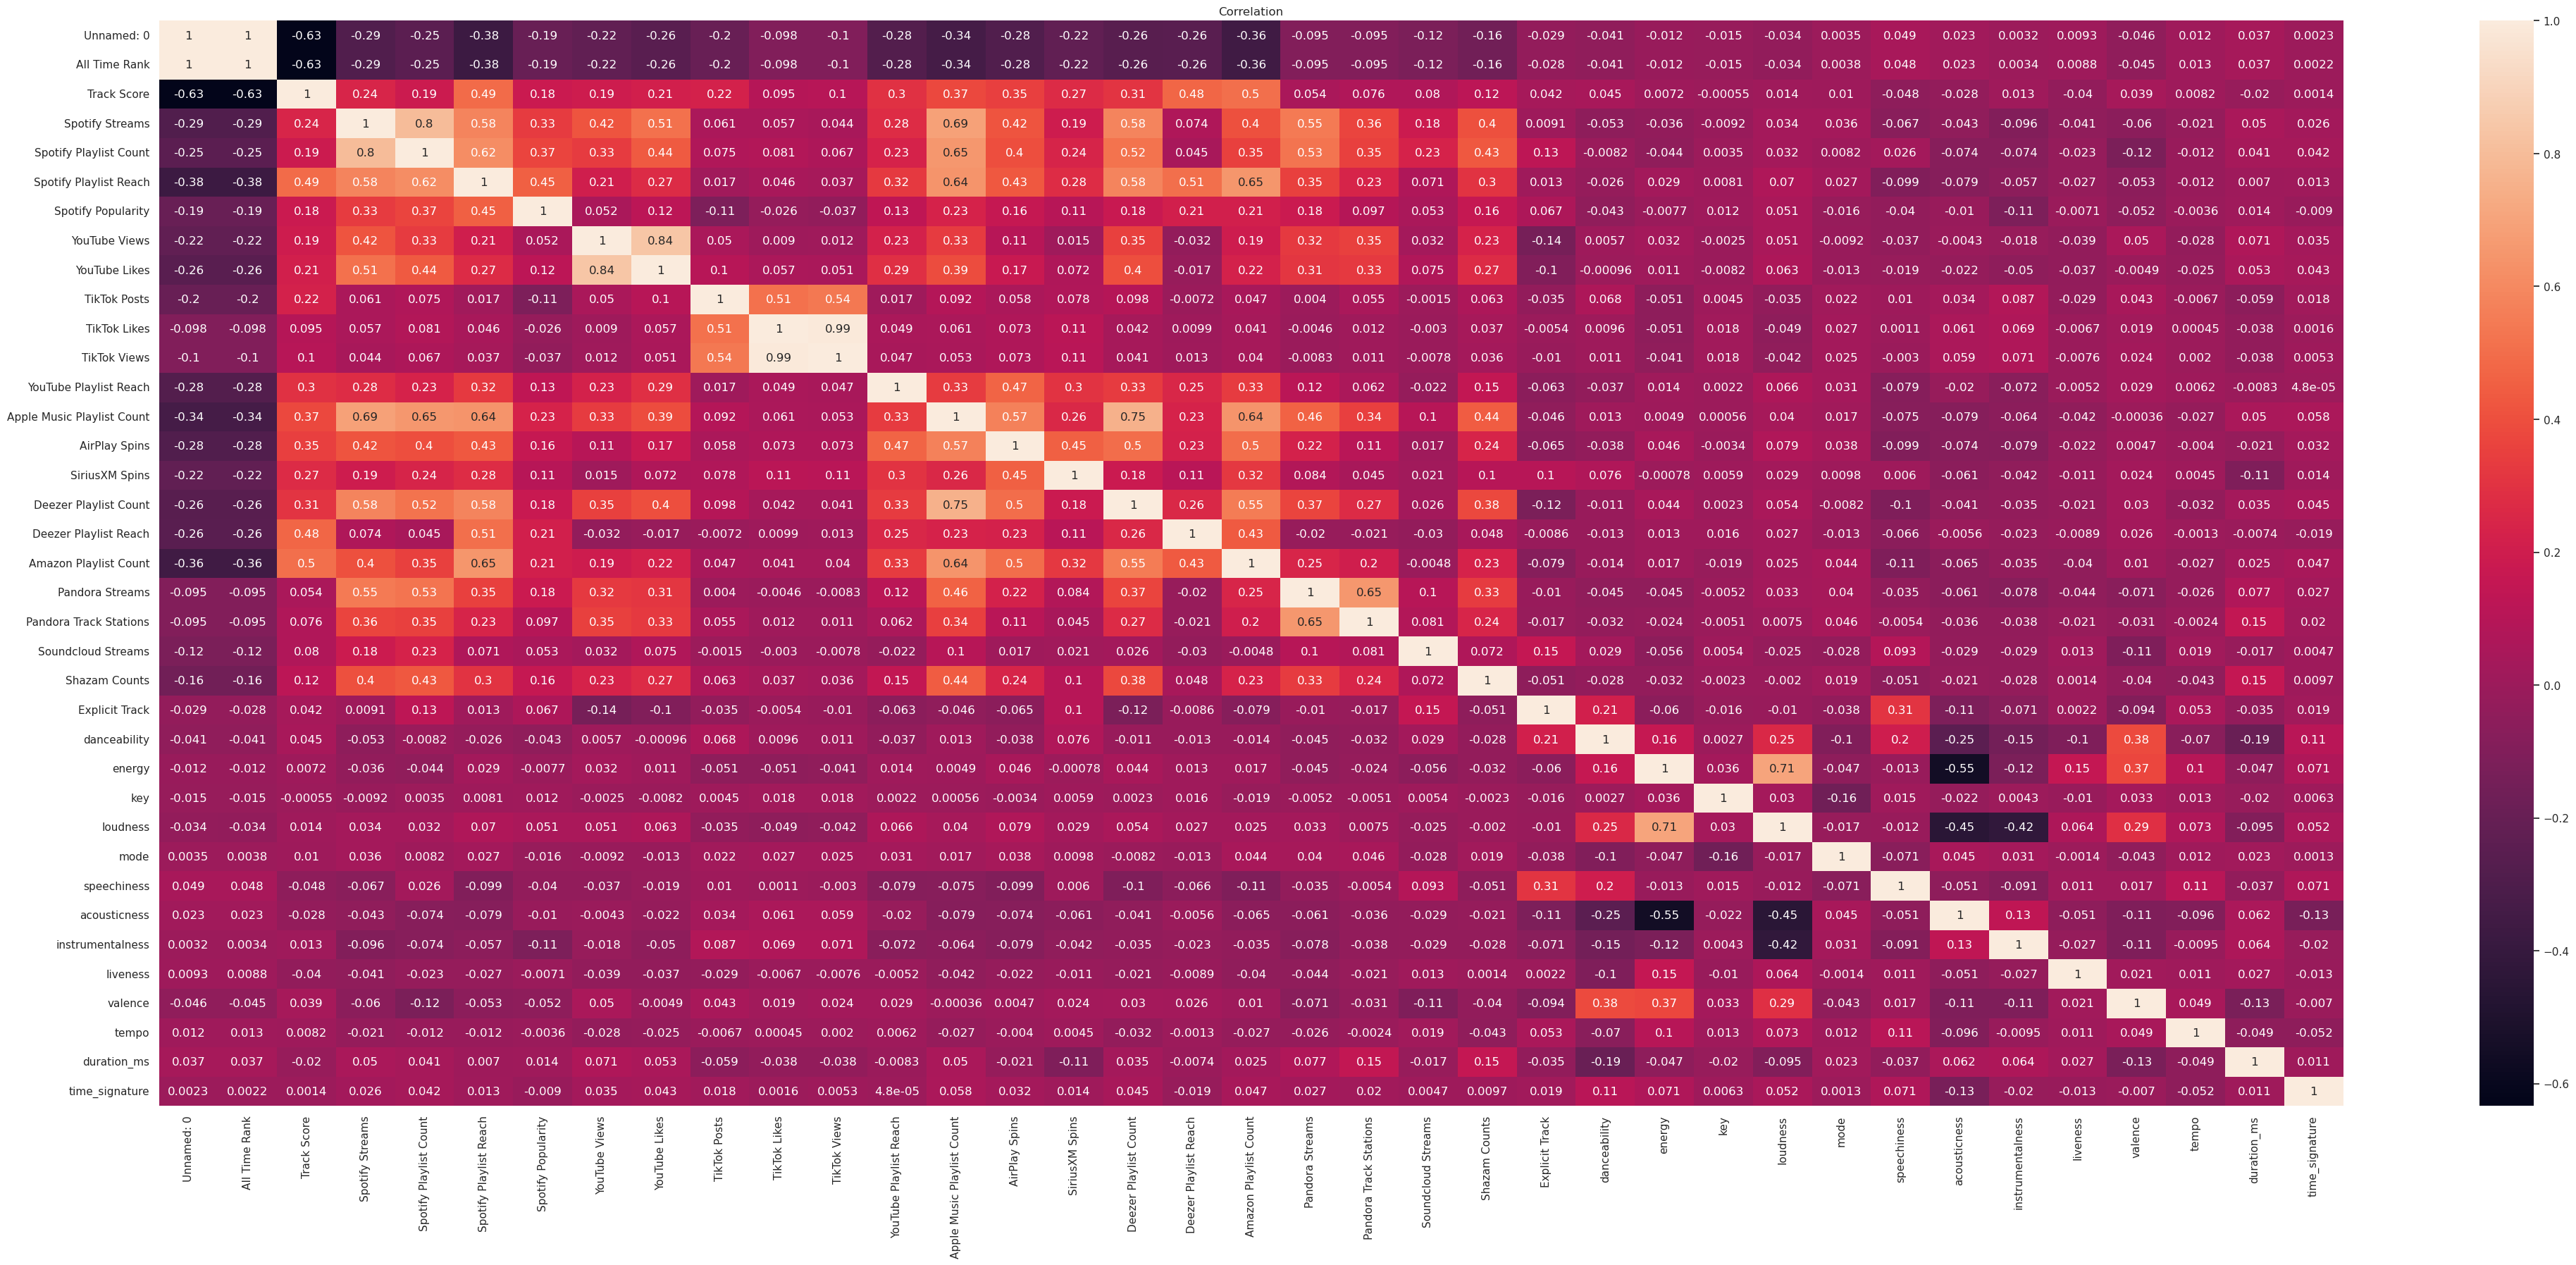

In [1041]:
# Check heatmap 

corr_matrix = df_original[numeric_cols].corr()

# Create a heatmap
plt.figure(figsize=(50, 20))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation')
plt.show()

# Categorization of the outcome variable

- **Danceability Classification**:
  - A function, `danceability_classifier`, was defined to classify the danceability feature into multi-class values:
    - 1 for very low danceability (if danceability < 0.4).
    - 2 for low danceability (if 0.4 ≤ danceability < 0.7).
    - 3 for medium danceability (if 0.7 ≤ danceability < 0.9).
    - 4 for high danceability (if danceability ≥ 0.9).

- **Binary Danceability Column Creation**:
  - A new column, `binary_danceability`, was created by applying the `danceability_classifier` function to the `danceability` feature.

- **Target and Feature Extraction**:
  - Extracted `binary_danceability` as the target variable (Y) for modeling.
  - Retained other processed features (X) for modeling but removed the original `danceability` and `binary_danceability` columns from the features.

- **Shape Verification**:
  - Verified the shapes of the features (X) and the target variable (Y):
    - X: (4600, 37) features, after including the newly created binary column.
    - Y: (4600, 1) target labels.

- **Data Shuffling**:
  - Shuffled the dataset to ensure randomness using NumPy's shuffle method with a predefined seed (`1234`) for reproducibility.

- **Train-Test-Validation Split**:
  - The dataset was split into training, validation, and test sets:
    - **Initial Split**: 80% training and 20% test data using `train_test_split` with a fixed `random_state=1234`.
    - **Further Split**: The training data was further divided into 80% training and 20% validation sets.
      - **Training Set**: 2,944 samples with 37 features each.
      - **Validation Set**: 736 samples with 37 features each.
      - **Test Set**: 920 samples with 37 features each.

In [1042]:
def danceability_classifier(x):
    '''
      Classifies the danceability param to either 1-low, 2-medium or 3-High
      Args:
      x: input decimal denoting deacneabiluty

      Returns:
       Either of the int values in 1,2,3 representing 1-low, 2-medium or 3-High

    '''
    if x >= 0.9:
        return 3
    elif 0.7 <= x  <0.9:
        return 2
    elif 0.4 <= x  <0.7:
        return 1
    else:
        return 0

In [1043]:
# Creating a deep copy for model use

df = copy.deepcopy(df_original)

In [1044]:
# Categorise the data set as Either danceable or not

df['binary_danceability'] = df['danceability'].apply(danceability_classifier)


In [1045]:
# Get the features and outcome variables separated for the onehot encoded dataset
Y=pd.DataFrame(df['binary_danceability'])
df.drop(['binary_danceability','danceability'],axis=1,inplace=True)
X=pd.DataFrame(df)

In [1046]:
Y.head()

,binary_danceability
0,2
1,2
2,1
3,2
4,3


In [1047]:
df_original['danceability'].median

<bound method Series.median of 0       0.852
1       0.898
2       0.599
3       0.706
4       0.936
        ...  
4595    0.844
4596    0.574
4597    0.824
4598    0.799
4599    0.808
Name: danceability, Length: 4600, dtype: float64>

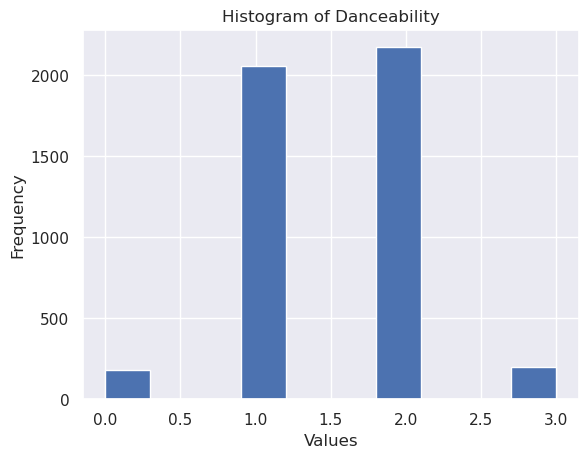

In [1048]:
# Create the histogram for the Y column
plt.hist(Y)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Danceability')
plt.show()

In [1049]:
X.head()

,Unnamed: 0,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,1,725.4,390470936,30716,196631588,92.0,84274754,1713126,5767700,...,-5.520,0.0,0.0439,0.097300,0.000370,0.0678,0.919,138.029,155152.0,4.0
1,1,2,545.9,323703884,28113,174597137,92.0,116347040,3486739,674700,...,-7.001,1.0,0.0776,0.010700,0.000000,0.1410,0.214,101.061,274192.0,4.0
2,2,3,538.4,601309283,54331,211607669,92.0,122599116,2228730,3025400,...,-4.263,1.0,0.0447,0.000938,0.010600,0.0826,0.747,151.647,142515.0,4.0
3,3,4,444.9,2031280633,269802,136569078,85.0,1096100899,10629796,7189811,...,-4.775,1.0,0.0633,0.058400,0.000070,0.0232,0.632,118.048,200600.0,4.0
4,4,5,423.3,107034922,7223,151469874,88.0,77373957,3670188,16400,...,-2.760,0.0,0.0683,0.029200,0.000002,0.0582,0.889,127.003,227239.0,4.0


In [1050]:
print("X shape:", X.shape,"Y shape:",Y.shape)

X shape: (4600, 36) Y shape: (4600, 1)


In [1051]:
# Convert to numpy array
X=np.array(X)
Y=np.array(Y)

In [1052]:
# Shuffle data
# NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle data
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)

# Re-order using the list of shuffled indices
X = X[indices]
Y = Y[indices]

In [1053]:
# Split the (X,Y) data into training and test paritions

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234)

# EX2.2
# Print the shape of each array.
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (2944, 36)
X_test shape: (920, 36)
X_val shape: (736, 36)
Y_train shape: (2944, 1)
Y_test shape: (920, 1)
Y_val shape: (736, 1)


# Modeling

### Baseline Model

- **Artist-Based Prior Beliefs**:
  - Attempted to calculate the average danceability for each artist to establish prior beliefs about their songs' danceability levels.
  - Encountered a `KeyError: 'Artist'`, preventing the successful implementation of this step.
  - When artist-specific data was unavailable, the overall average danceability across all tracks was intended as a filler but not executed due to the error.

- **Energy-to-Danceability Baseline**:
  - Introduced a simple baseline assuming a direct correlation between energy and danceability.
  - **Binning Process**:
    - Both `energy` and `danceability` were binned into four categories based on thresholds:
      - Bin 0: Very low (0.0 to 0.4).
      - Bin 1: Low (0.4 to 0.7).
      - Bin 2: Medium (0.7 to 0.9).
      - Bin 3: High (0.9 to 1.0).
    - Created new columns: `energy_binned_value` and `danceability_binned_value` to represent the binned values.

- **Accuracy Calculation**:
  - Compared `energy_binned_value` and `danceability_binned_value` to calculate baseline accuracy.
  - **Results**:
    - Baseline accuracy: **41.28%**, showing the limitations of assuming a simple direct correlation between energy and danceability.

In [1054]:
# Baseline value assumes that danceable songs are energetic
# Therefore this baseline is when it is assumed that energy has a direct correlation to danceability

# Define bin edges similar to danceability classifier
bins = [0, 0.4, 0.7, 0.90, 1]
df_original['energy_binned_value'] = pd.cut(df_original['energy'], bins=bins, labels=False)
df_original['danceability_binned_value'] = pd.cut(df_original['danceability'], bins=bins, labels=False)

# Count occurrences of each bin
energy_bin_counts = df_original['energy_binned_value'].value_counts().sort_index()
danceability_bin_counts = df_original['danceability_binned_value'].value_counts().sort_index()

print(energy_bin_counts)
print(danceability_bin_counts)


# Calculate accuracy
accuracy = (df_original['energy_binned_value'] == df_original['danceability_binned_value']).mean()

print("\n Baseline accuracy:", accuracy)

energy_binned_value
0     384
1    2235
2    1682
3     299
Name: count, dtype: int64
danceability_binned_value
0     186
1    2058
2    2164
3     192
Name: count, dtype: int64

 Baseline accuracy: 0.41978260869565215


## Advanced Models

### Scikit-Learn HistGradientBoostingClassifier Model

- **Model Selection**:
  - Chose a scikit-learn `HistGradientBoostingClassifier` as the model for this iteration, leveraging its ability to handle numerical data efficiently.

- **Training the Model**:
  - Filled missing values in `X_train` with zeros to ensure compatibility with the model.
  - Trained the `HistGradientBoostingClassifier` using the prepared training data (`X_train`, `Y_train`).

- **Validation Predictions**:
  - Made predictions on the validation set (`X_val`) using the trained model.

- **Performance Evaluation**:
  - Calculated the validation accuracy using scikit-learn's `accuracy_score` function.
  - **Results**:
    - Validation accuracy: **49.05%**, indicating modest predictive performance for the model.

In [1064]:
# Make predictions on validation set
def prediction_scores():
    y_pred = model.predict(X_val)


    # Evaluate the model on validation data set
    accuracy = accuracy_score(y_pred, Y_val)
    mse=np.mean((Y_val - y_pred)**2)

    print("### Validation data set evaluation: \n")
    print("Validation Accuracy:", accuracy,"\n")
    print("Validation MSE:", mse,"\n")

    # Make predictions on test data set
    y_pred_test = model.predict(X_test)

    # Evaluate the model on test data
    accuracy = accuracy_score(y_pred_test, Y_test)
    mse =  mean_squared_error(y_pred_test, Y_test)
    precision = precision_score(y_pred_test, Y_test, average=None, zero_division=0)
    recall = recall_score(y_pred_test, Y_test, average=None)
    f1 = f1_score(y_pred_test, Y_test, average=None)  
    mae = mean_absolute_error(y_pred_test, Y_test)


    print("\n### Test data set evaluation: \n")
    print("Accuracy:", accuracy,"\n")
    print("Mean Squared Error (MSE):", mse,"\n")
    print("Mean Absolute Error (MAE):", mae) 
    print("Precision:", precision,"\n")
    print("Recall:", recall,"\n")
    print("F1 Score:", f1,"\n")

    # Plot the confusion matrix for test data



    # Create the confusion matrix
    cm = confusion_matrix(Y_test, y_pred_test)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()



In [1062]:
Y_train.shape

(2944, 1)

/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Validation data set evaluation: 

Validation Accuracy: 0.48641304347826086 

Validation MSE: 0.6451219872400756 


### Test data set evaluation: 

Accuracy: 0.4489130434782609 

Mean Squared Error (MSE): 0.6934782608695652 

Mean Absolute Error (MAE): 0.5978260869565217
Precision: [0.    0.279 0.708 0.   ] 

Recall: [0.    0.471 0.445 0.   ] 

F1 Score: [0.    0.35  0.547 0.   ] 



/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


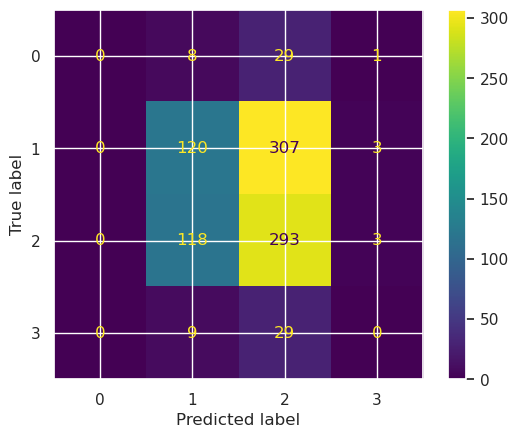

In [1065]:
# LOGISTIC REGRESSION
from sklearn.preprocessing import StandardScaler

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# #new_X=np.array(new_X)
# new_Y=Y_train.ravel()

# Create the model
model = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')

# Train the model
model.fit(X_train, Y_train)

prediction_scores()



/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Validation data set evaluation: 

Validation Accuracy: 0.6820652173913043 

Validation MSE: 0.6779559014650284 


### Test data set evaluation: 

Accuracy: 0.7065217391304348 

Mean Squared Error (MSE): 0.3032608695652174 

Mean Absolute Error (MAE): 0.2967391304347826
Precision: [0.184 0.7   0.819 0.079] 

Recall: [0.778 0.749 0.673 0.6  ] 

F1 Score: [0.298 0.724 0.739 0.14 ] 



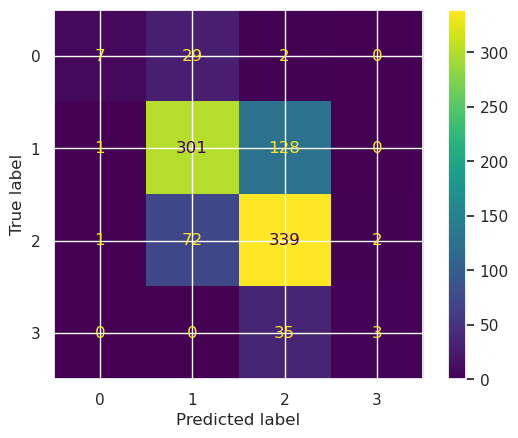

In [1066]:

# HistGradientBoostingClassifier

# Create the model
model = HistGradientBoostingClassifier(learning_rate=0.01, max_iter=1000, max_leaf_nodes=100)

# Train the model
model.fit(X_train, Y_train)

# Make predictions
y_pred = model.predict(X_val)

# Print the evaluation metrics

prediction_scores()


### Random Forest

- **Model Setup**:
  - Utilized scikit-learn's `RandomForestClassifier` with the following key parameters:
    - `n_estimators`: 500 (number of decision trees in the forest).
    - `max_depth`: 5 (maximum depth of each tree).
    - `bootstrap`: False (sampling without replacement).
    - `random_state`: 0 (to ensure reproducibility).

- **Training the Model**:
  - Trained the random forest model using the training data (`X_train`, `Y_train`).

- **Performance Evaluation**:
  - Evaluated the model's performance on the training, validation, and test sets:
    - **Training Accuracy**: 47.38%.
    - **Validation Accuracy**: 49.05%.
    - **Test Accuracy**: 45.00%.

- **Error Metrics on Test Data**:
  - **Mean Squared Error (MSE)**: 0.7098.
  - **Mean Absolute Error (MAE)**: 0.6033.

- **Confusion Matrices**:
  - Generated confusion matrices to assess the distribution of predicted versus actual classes:
    - Displayed a heatmap for the validation set confusion matrix.
    - Provided a confusion matrix for the test set to visualize performance.

- **Observations**:
  - The random forest model achieved similar accuracy to previous models, indicating room for improvement in feature engineering or model tuning.

/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Validation data set evaluation: 

Validation Accuracy: 0.6589673913043478 

Validation MSE: 0.656375531663516 


### Test data set evaluation: 

Accuracy: 0.6815217391304348 

Mean Squared Error (MSE): 0.325 

Mean Absolute Error (MAE): 0.32065217391304346
Precision: [0.132 0.67  0.807 0.   ] 

Recall: [0.714 0.722 0.65  0.   ] 

F1 Score: [0.222 0.695 0.72  0.   ] 



/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


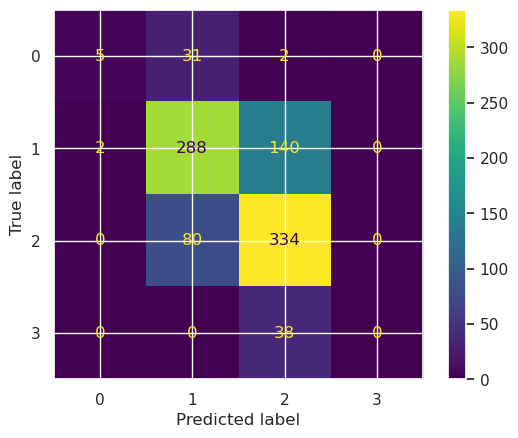

In [1067]:
# Random Forest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
 
# Create a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=100, bootstrap=True)

# Train the model
model.fit(X_train, Y_train)

y_train_pred=model.predict(X_train)
# Make predictions on the validation set
prediction_scores()


### Neural Network

- **Model Architecture**:
  - Built a neural network using TensorFlow's Keras API with the following layers:
    1. Input layer with 64 units, ReLU activation, and bias initialized to ones.
    2. Hidden layer with 32 units and ReLU activation.
    3. Output layer with a single unit and softmax activation.

- **Compilation**:
  - Optimizer: Adam with a learning rate of 0.001.
  - Loss function: Categorical Crossentropy.
  - Metric: Accuracy.

- **Training**:
  - Converted the training and validation datasets (`X_train`, `X_val`) to TensorFlow tensors.
  - Trained the model over 20 epochs using the validation set (`Y_val`) for evaluation.

- **Performance Results**:
  - Accuracy remained low throughout training:
    - **Training Accuracy**: ~4.94%.
    - **Validation Accuracy**: ~3.40%.
  - Loss values for both training and validation remained at zero, indicating potential issues with model setup or data preprocessing.

- **Test Evaluation**:
  - Evaluated the model on the test dataset (`X_test`):
    - **Test Accuracy**: ~5.33%.

- **Challenges Observed**:
  - Softmax activation in the output layer was not ideal for this multi-class classification with a single output unit.
  - Categorical Crossentropy was mismatched to the model structure and task, potentially contributing to the poor performance.

- **Suggestions for Improvement**:
  - Replace softmax with sigmoid activation for binary classification tasks or restructure the output layer for proper multi-class classification.
  - Adjust the loss function to match the output activation (e.g., Binary Crossentropy for sigmoid).
  - Revisit feature scaling and data preprocessing to ensure compatibility with neural network training.

In [1072]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=64,        # hmn output dim
      input_shape=(num_features,),  # hmn input dim
      #input_dim=num_features,
      use_bias=True,               # use a bias (intercept) param
      activation='relu', # hmn
      kernel_initializer='Ones',  # initialize params to 1
      bias_initializer='Ones',    # initialize bias to 1
  ))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dense(units=1, activation='softmax'))
  
  # We need to choose an optimizer. 
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) 

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile( optimizer=optimizer, metrics=['accuracy'], loss='categorical_crossentropy')
    
  return model

In [1079]:
#tf.random.set_seed(0)
# 2. Build and compile model
num_features = X_train.shape[1]
learning_rate = 0.01
epochs=5
model=build_model(num_features, learning_rate)


# 3. Fit the model
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
results=model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), verbose=True)

Epoch 1/5


/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4184 - loss: 0.0000e+00 - val_accuracy: 0.4307 - val_loss: 0.0000e+00
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4184 - loss: 0.0000e+00 - val_accuracy: 0.4307 - val_loss: 0.0000e+00
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4184 - loss: 0.0000e+00 - val_accuracy: 0.4307 - val_loss: 0.0000e+00
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4184 - loss: 0.0000e+00 - val_accuracy: 0.4307 - val_loss: 0.0000e+00
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4184 - loss: 0.0000e+00 - val_accuracy: 0.4307 - val_loss: 0.0000e+00


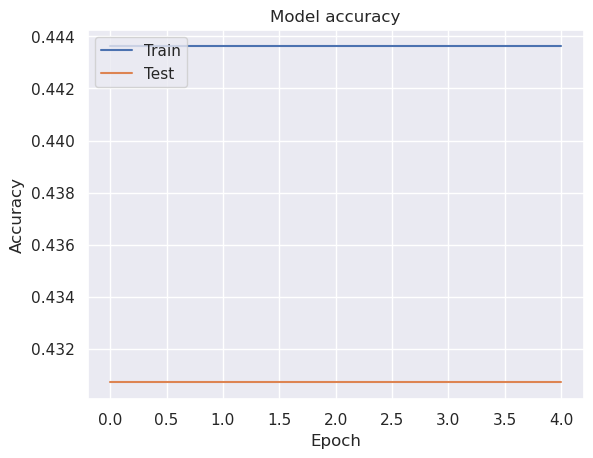

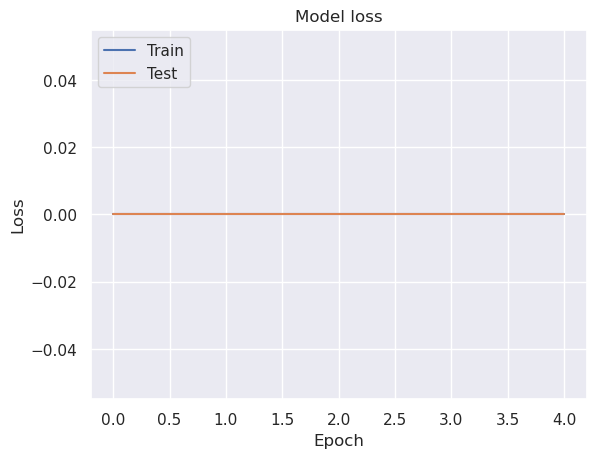

In [1080]:
# Plot training history

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [1081]:
print("\nFirst 5 Learned Parameters:")
for layer in model.layers:
    print("\n",layer.get_weights()[0][:5]),
    print("\nBias term:",layer.get_weights()[1])


# EX 10.3 The loss at the final epoch on both the mini training and validation datasets;
print("\nLoss at Final Epoch:")
print('\nTraining Loss: ', results.history['loss'][-1])
print('\nValidation Loss:', results.history['val_loss'][-1])

# EX 10.4 The percentage difference between the losses observed on the mini training and validation datasets
if results.history['loss'][-1] != 0 :
    loss_diff  =( results.history['loss'][-1]-results.history['val_loss'][-1] )/results.history['loss'][-1]
    print(f'\nLoss Difference (%):, {loss_diff * 100:.2f} %')


First 5 Learned Parameters:

 [[9.445 9.481 9.486 9.519 9.49  9.397 9.506 9.46  9.352 9.477 9.364 9.381
  9.385 9.453 9.49  9.524 9.421 9.404 9.432 9.501 9.489 9.518 9.412 9.367
  9.385 9.456 9.433 9.279 9.391 9.379 9.342 9.502 9.479 9.353 9.434 9.389
  9.479 9.457 9.506 9.441 9.47  9.483 9.51  9.313 9.391 9.465 9.362 9.492
  9.534 9.508 9.446 9.425 9.411 9.329 9.493 9.47  9.428 9.437 9.416 9.341
  9.413 9.382 9.401 9.467]
 [9.444 9.48  9.486 9.519 9.489 9.397 9.505 9.46  9.352 9.476 9.363 9.38
  9.384 9.453 9.49  9.523 9.42  9.404 9.431 9.501 9.488 9.517 9.412 9.366
  9.385 9.455 9.432 9.278 9.39  9.378 9.341 9.501 9.479 9.352 9.434 9.388
  9.479 9.456 9.505 9.441 9.469 9.482 9.509 9.313 9.391 9.464 9.362 9.492
  9.533 9.507 9.445 9.424 9.41  9.328 9.492 9.47  9.427 9.436 9.415 9.34
  9.412 9.381 9.4   9.467]
 [9.386 9.424 9.429 9.46  9.431 9.344 9.449 9.403 9.295 9.417 9.311 9.327
  9.329 9.392 9.425 9.464 9.362 9.354 9.372 9.442 9.435 9.462 9.361 9.307
  9.329 9.398 9.381 9.227 9.3

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
### Validation data set evaluation: 

Validation Accuracy: 0.43070652173913043 

Validation MSE: 0.7160326086956522 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

### Test data set evaluation: 

Accuracy: 0.4673913043478261 

Mean Squared Error (MSE): 0.6565217391304348 

Mean Absolute Error (MAE): 0.5739130434782609
Precision: [0. 1. 0. 0.] 

Recall: [0.    0.467 0.    0.   ] 

F1 Score: [0.    0.637 0.    0.   ] 



/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/ubuntuv1/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


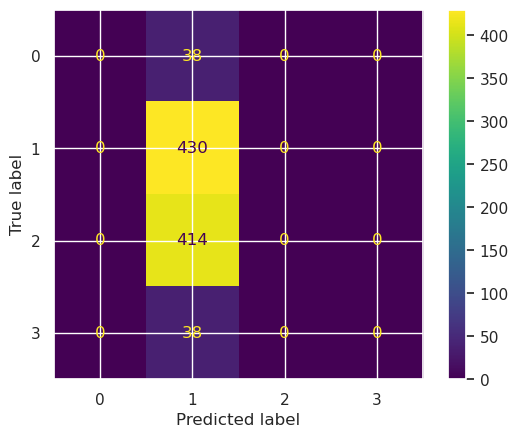

In [1082]:
prediction_scores()